In [64]:
import numpy as np
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
import phate
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [65]:
adata_all = sc.read('../data/balanced_subsampled2.h5ad')
# adata = adata_all[subsampled_df.index]
adata = adata_all

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [66]:
# scaler = StandardScaler()
# adata.obsm['X_phate'] = scaler.fit_transform(adata.obsm['X_phate'])

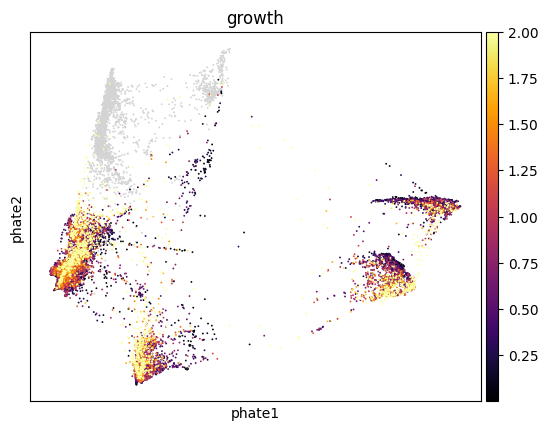

In [67]:
sc.external.pl.phate(adata, color='growth', cmap='inferno', vmax=2)

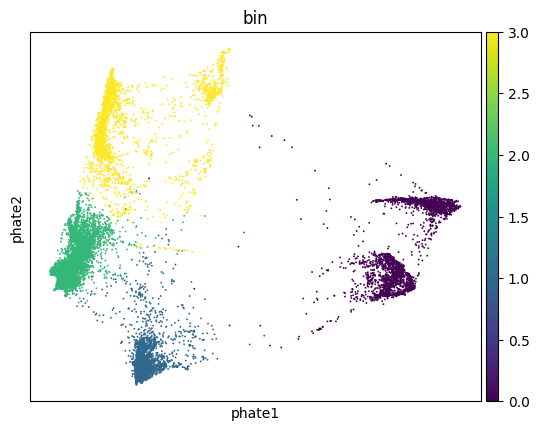

In [68]:
sc.external.pl.phate(adata, color='bin')

In [69]:
from ot.unbalanced import sinkhorn_knopp_unbalanced
from scipy.spatial.distance import cdist

def get_transform_matrix(gamma, a, epsilon=1e-8):
    return (np.diag(1.0 / (a+ epsilon)) @ gamma).T

def get_growth_coeffs(gamma, a, epsilon=1e-8, normalize=False):                                                                         
    T = get_transform_matrix(gamma, a, epsilon)                                                                                         
    unnormalized_coeffs = np.sum(T, axis=0)                                                                                             
    if not normalize:                                                                                                                   
        return unnormalized_coeffs                                                                                                      
    return unnormalized_coeffs / np.sum(unnormalized_coeffs) * len(unnormalized_coeffs)   

def calc_growth(source, target):
    # alpha = 2
    alpha = 4
    a = adata.obsm['X_pca'][adata.obs['bin'] == source]
    b = adata.obsm['X_pca'][adata.obs['bin'] == target]
    m, n = a.shape[0], b.shape[0]
    M = cdist(a,b)
    entropy_reg = 0.1
    # reg_1, reg_2 = alpha, 10000
    reg_1, reg_2 = alpha, 10_000
    gamma = sinkhorn_knopp_unbalanced(np.ones(m) / m, np.ones(n) / n, M, entropy_reg, reg_1, reg_2)
    return get_growth_coeffs(gamma, np.ones(m) / m)

In [70]:
samples = [0,1,2,3,4]
dfs = []
for i in range(len(samples)):
    if i == 0:
        continue
    gc = calc_growth(samples[i - 1], samples[i])
    index = adata.obs.index[adata.obs['bin'] == samples[i-1]]
    df = pd.DataFrame(gc, index=index)
    dfs.append(df)
df = pd.concat(dfs)
df.columns = ['growth1']
dff = pd.concat([adata.obs[adata.obs['bin'] != 4], df], axis=1)
dff = dff.drop('growth', axis=1)
dff = dff.rename(columns={'growth1': 'growth'})


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/ot/unbalanced.py:403: RuntimeWarning: divide by zero encountered in divide
  u = (a / Kv) ** fi
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/ot/unbalanced.py:412: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


<Axes: >

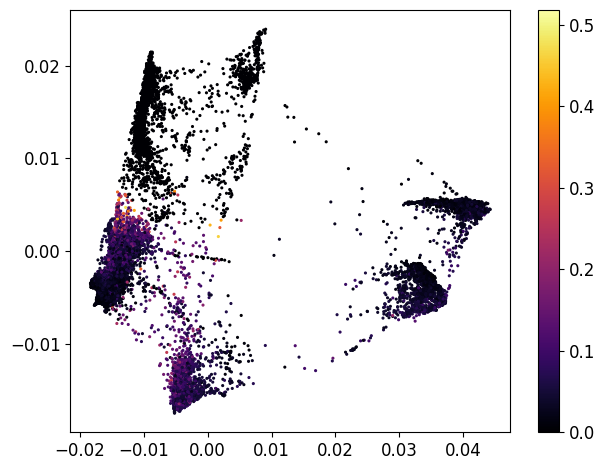

In [71]:
scprep.plot.scatter2d(adata[adata.obs['bin'] != 4].obsm['X_phate'].toarray(), dff['growth'].clip(upper=2), cmap='inferno')

<Axes: >

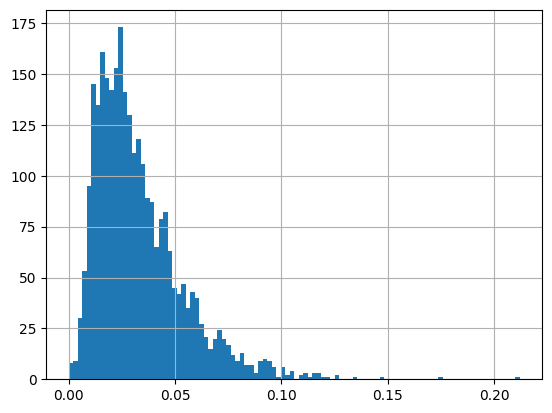

In [72]:
dff.loc[dff['bin'] == 0, 'growth'].hist(bins=100)

<Axes: >

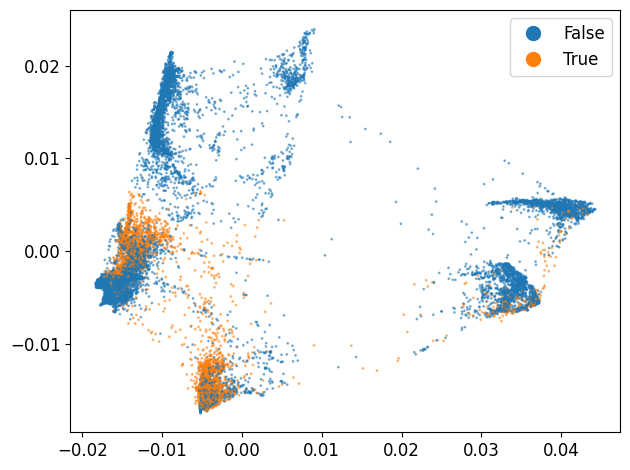

In [73]:
scprep.plot.scatter2d(adata[adata.obs['bin'] != 4].obsm['X_phate'].toarray(), dff['growth']>0.06, s=1, alpha=0.5)

<Axes: >

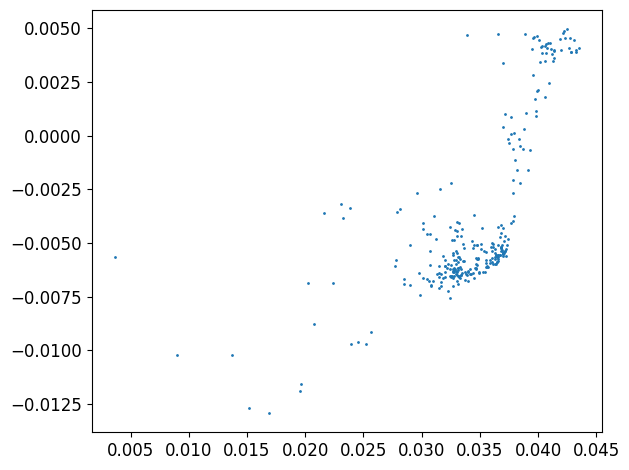

In [74]:
desired_index = list(set(dff.index[dff['growth']>0.06]).intersection(set(adata[adata.obs['bin'] == 0].obs_names)))
scprep.plot.scatter2d(adata[desired_index].obsm['X_phate'].toarray(), s=1)

In [75]:
(dff.loc[dff['bin'] == 0, 'growth'] > 0.06).mean()

0.10257314064152273

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1    1626
0    1211
dtype: int64

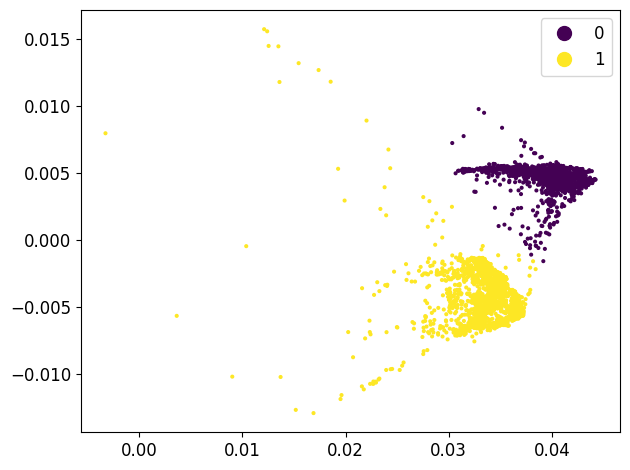

In [76]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, random_state=0).fit(adata[adata.obs['bin'] == 0].obsm['X_phate'].toarray())
scprep.plot.scatter2d(adata[adata.obs['bin'] == 0].obsm['X_phate'].toarray(), km.labels_, cmap='viridis')
pd.Series(km.labels_).value_counts()

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1    223
0     68
dtype: int64

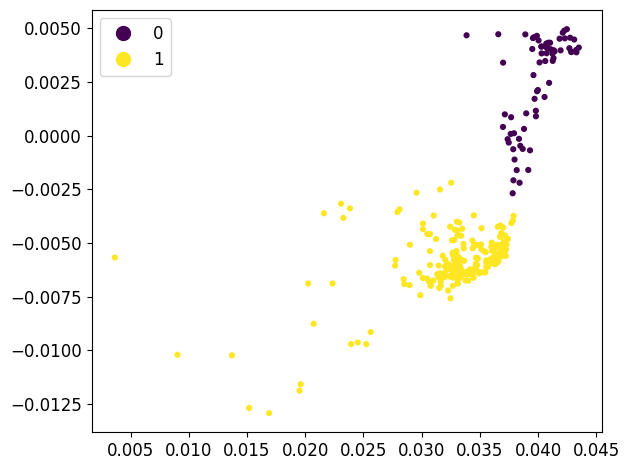

In [77]:
desired_index = list(set(dff.index[dff['growth']>0.06]).intersection(set(adata[adata.obs['bin'] == 0].obs_names)))
adata_sub = adata[desired_index].copy()
km = KMeans(n_clusters=2, random_state=0).fit(adata_sub.obsm['X_phate'])
scprep.plot.scatter2d(adata_sub.obsm['X_phate'], km.labels_, cmap='viridis')
pd.Series(km.labels_).value_counts()


In [78]:
dff['growth'].to_csv('../data/growth_rate2.csv')

In [79]:
adata_all = sc.read('../data/balanced_subsampled2.h5ad')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [80]:
adata_all.obs['growth'].to_csv('../data/growth_rate_alex.csv')